In [2]:
import sys

sys.path.append('..')

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from dataset import ase_atoms_to_jraph_graph, generative_sequence
from qm9 import load_qm9

In [3]:
def draw_graph(
    positions: jnp.ndarray,
    senders: jnp.ndarray,
    receivers: jnp.ndarray,
    node_color: jnp.ndarray = None,
    edge_color: jnp.ndarray = None,
    title: str = None,
):
    positions -= positions.mean(axis=0)

    # if len(positions) > 1:
    #     cov = np.cov(positions.T)
    #     _, v = jnp.linalg.eigh(cov)
    #     positions = positions @ v

    if edge_color is None:
        edge_color = jnp.zeros_like(senders)
    if node_color is None:
        node_color = jnp.zeros_like(positions[:, 0])

    edge_color = edge_color.astype(jnp.float32)

    plt.scatter(
        positions[:, 1], positions[:, 2], c=node_color, zorder=2, s=100, vmin=0, vmax=1
    )
    plt.axis("equal")
    for s, r, c in zip(senders, receivers, edge_color):
        c = plt.cm.tab10(c)
        plt.plot(positions[[s, r], 1], positions[[s, r], 2], zorder=1, color=c)

    if title is not None:
        plt.title(title)

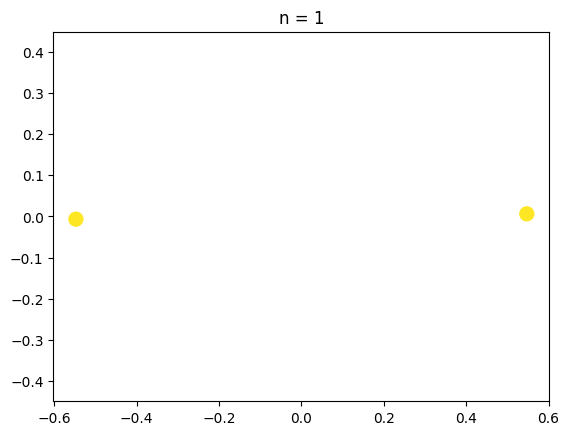

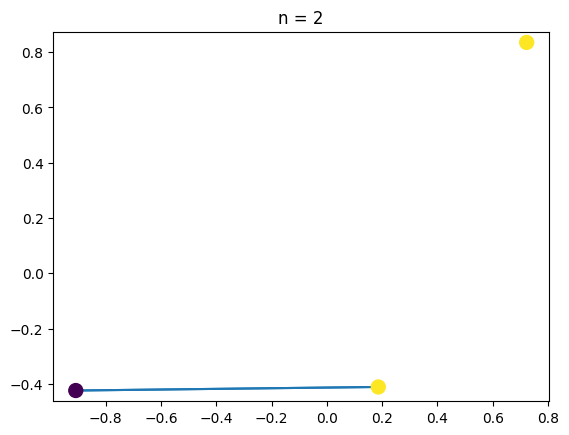

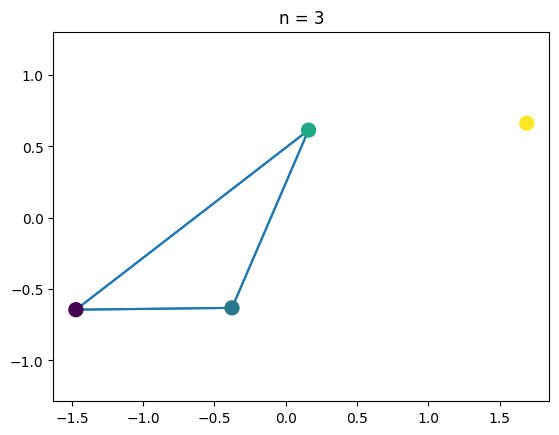

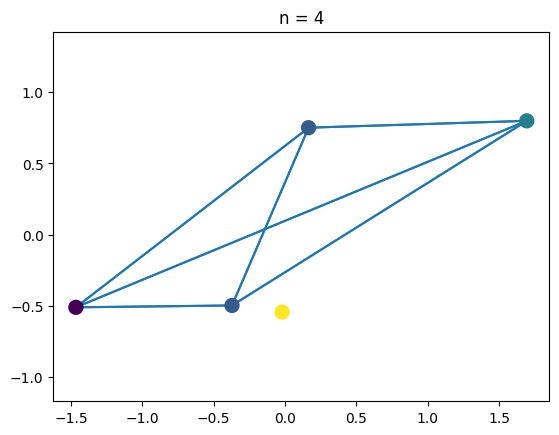

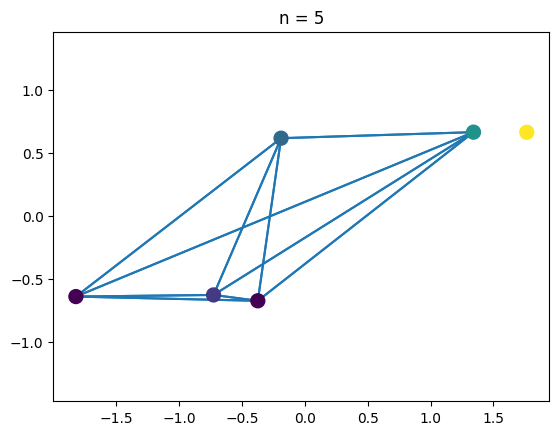

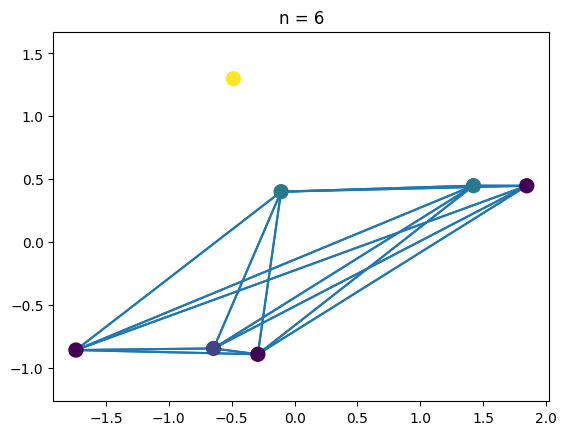

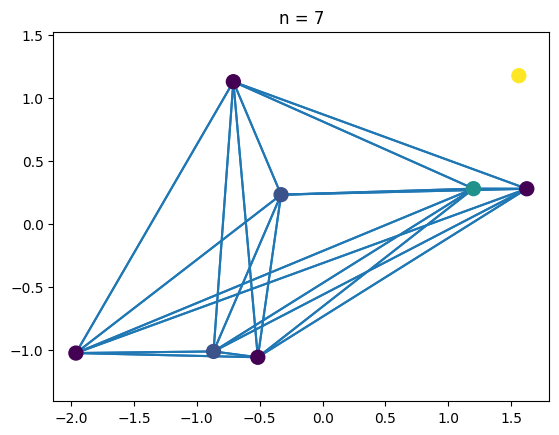

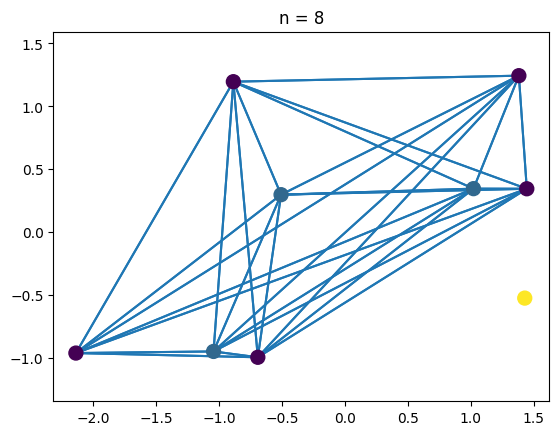

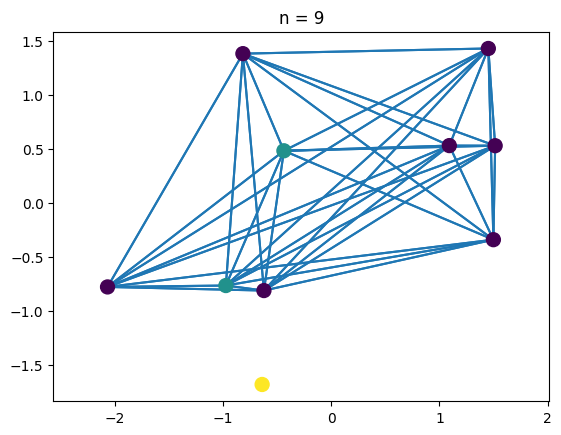

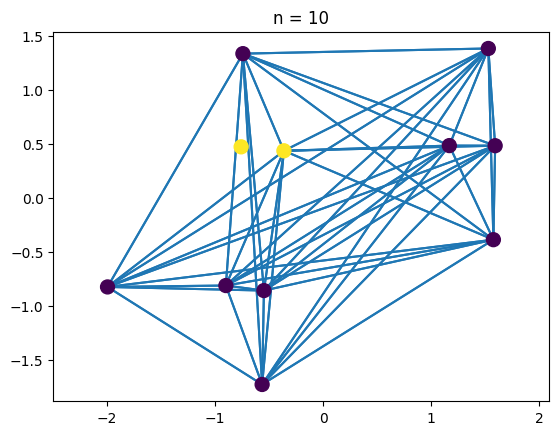

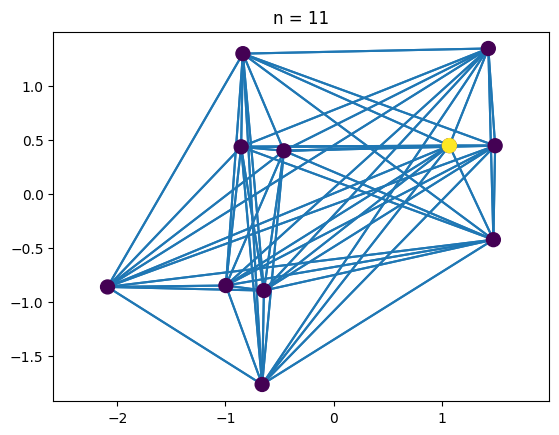

In [15]:
atoms = load_qm9("qm9_data")[12]
graph = ase_atoms_to_jraph_graph(atoms, cutoff=5.0)


for graph in generative_sequence(
    jax.random.PRNGKey(2), graph, jnp.array([1, 6, 7, 8, 9]), epsilon=0.5
):
    plt.figure()
    n = len(graph.nodes.positions)
    draw_graph(
        jnp.concatenate(
            [
                graph.nodes.positions,
                graph.nodes.positions[0] + graph.globals.target_position,
            ]
        ),
        graph.senders,
        graph.receivers,
        # node_color=jnp.array([0] + [1] * (n - 1) + [2]),
        node_color=jnp.concatenate([graph.nodes.focus_probability, jnp.array([1.0])]),
        title=f"n = {n}",
    )


In [16]:
qm9 = load_qm9("qm9_data")

In [17]:
import collections

collections.Counter([frozenset(x.get_atomic_numbers()) for x in qm9])

Counter({frozenset({1, 6}): 4907,
         frozenset({1, 7}): 1,
         frozenset({1, 8}): 1,
         frozenset({1, 6, 7}): 14198,
         frozenset({1, 6, 8}): 45770,
         frozenset({1, 6, 7, 8}): 66814,
         frozenset({6, 7}): 4,
         frozenset({7, 8}): 1,
         frozenset({6, 9}): 2,
         frozenset({6, 7, 8}): 26,
         frozenset({1, 6, 9}): 96,
         frozenset({6, 7, 9}): 3,
         frozenset({1, 6, 8, 9}): 250,
         frozenset({1, 6, 7, 9}): 736,
         frozenset({1, 6, 7, 8, 9}): 1062,
         frozenset({6, 7, 8, 9}): 14})

In [18]:
import tqdm

In [19]:
small_qm9 = [x for x in qm9 if set(x.get_atomic_numbers()) == {1, 6}]
len(small_qm9)

collections.Counter([len(x) for x in small_qm9])

Counter({5: 1,
         4: 1,
         8: 2,
         7: 1,
         11: 5,
         9: 3,
         14: 24,
         6: 1,
         10: 3,
         12: 9,
         17: 170,
         13: 14,
         15: 38,
         16: 67,
         20: 289,
         18: 190,
         19: 512,
         23: 1247,
         21: 1103,
         26: 18,
         24: 73,
         22: 221,
         25: 695,
         27: 185,
         29: 35})

In [20]:
# for x in tqdm.tqdm(small_qm9):
#     list(generative_sequence(jax.random.PRNGKey(2), ase_atoms_to_jraph_graph(x, cutoff=5.0)))

x = small_qm9[1]
graphs = list(generative_sequence(jax.random.PRNGKey(2), ase_atoms_to_jraph_graph(x, cutoff=5.0), jnp.array([1, 6, 7, 8, 9]), epsilon=1.0))

len(graphs)

4

In [21]:
import jraph

In [22]:
jraph.batch_np(graphs)

GraphsTuple(nodes=TrainingNodesInfo(positions=array([[ 1.6616,  0.    ,  1.    ],
       [ 0.5995,  0.    ,  1.    ],
       [ 1.6616,  0.    ,  1.    ],
       [-0.5995,  0.    ,  1.    ],
       [ 1.6616,  0.    ,  1.    ],
       [ 0.5995,  0.    ,  1.    ],
       [ 0.5995,  0.    ,  1.    ],
       [-0.5995,  0.    ,  1.    ],
       [-1.6616,  0.    ,  1.    ],
       [ 1.6616,  0.    ,  1.    ]]), species=array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0], dtype=int32), focus_probability=array([1., 1., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)), edges=None, receivers=array([1, 2, 5, 5, 3, 3, 4, 4, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]), senders=array([2, 1, 3, 4, 5, 4, 5, 3, 7, 8, 9, 6, 8, 9, 6, 7, 9, 6, 7, 8]), globals=TrainingGlobalsInfo(stop=array([False, False, False,  True]), target_specie_probability=array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32), target_specie=array([1, 1, 0, 1], dtype=int32), targ

In [23]:
{z for x in qm9 for z in x.get_atomic_numbers()}

{1, 6, 7, 8, 9}

In [24]:
jnp.searchsorted(jnp.array([1, 6, 7]), 7)

Array(2, dtype=int32)

In [25]:
species = jnp.array([0, 2, 2])
atomic_numbers = jnp.array([1, 6, 7, 8])

jnp.bincount(species, length=len(atomic_numbers)) / len(species)

Array([0.33333334, 0.        , 0.6666667 , 0.        ], dtype=float32)